In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from datetime import datetime
import dolfin as df

## Convert concentrations to hdf 

Firstly, we map the MRI concentration data from `mgz`-format to fenics-functions defined on the brain mesh. We make use of basically the same functions as presented in the book chapter on tracer concentrations. 

However, to simplify reading and storing data and results, we make use of the homemade class `FenicsStorage` which is a wrapper around FEniCS `HDF5File`. The functions stores the mesh, concentration-data and simulations results in a single file, with several utility functions for storing and reading the necessary information relating to the data.

Finally, we've created a single function for mapping functions stored in `hdf`-files to `xdmf` for easier visualization in paraview. 

In [3]:
from meshprocessing import hdf2fenics
from fenicsstorage import FenicsStorage

from mri2fenics import (
    image_timestamp,
    read_image,
    injection_timestamp,
    fenicsstorage2xdmf
)

In [4]:
# Relevant filepaths
datapath = Path("data/")
meshfile = datapath / "brain32.h5"
hdfdata = datapath / "data.hdf"

In [5]:
# FEM element specification
femfamily = "CG"
femdegree = 1

# Load concentration data from MRI-images.
concentration_data = sorted((datapath / "concentrations").iterdir())

# Get correct time of injection.
start_date = image_timestamp(concentration_data[0]).date()
injection_time_of_day = injection_timestamp(datapath / "injection_time.txt")
t0 = datetime.combine(start_date, injection_time_of_day)

# Open storage-file and write mesh.
outfile = FenicsStorage(hdfdata, "w")
mesh, _, _ = hdf2fenics(meshfile)
outfile.write_domain(mesh)

# Map data from MRI to FEM-function on the mesh, and store to outfile.
V = df.FunctionSpace(mesh, femfamily, femdegree)
for cfile in concentration_data:
    c_data_fenics = read_image(filename=cfile, functionspace=V, data_filter=None)
    ti = max(0, (image_timestamp(cfile) - t0).total_seconds())
    outfile.write_checkpoint(c_data_fenics, name="cdata", t=ti)
outfile.close()

# Write to xdmf for visualization in paraview.
fenicsstorage2xdmf(outfile.filepath, "cdata", "cdata")

No filter used, setting 41639 / 183136  nan voxels to 0
No filter used, setting 41639 / 183136  nan voxels to 0
No filter used, setting 41480 / 183136  voxels in mesh have value < 0
No filter used, setting 41639 / 183136  nan voxels to 0
No filter used, setting 12776 / 183136  voxels in mesh have value < 0
No filter used, setting 41639 / 183136  nan voxels to 0
No filter used, setting 3916 / 183136  voxels in mesh have value < 0
No filter used, setting 41639 / 183136  nan voxels to 0
No filter used, setting 8575 / 183136  voxels in mesh have value < 0


## Run Simulations

Now we run both the diffusion-model and a two-compartment diffusion model, so that we may compare the results from the two ways. Most of the relevant code for the simulations are implemented in the files `diffusion_model.py` and `multidiffusion_model.py`.

### Diffusion model

In [6]:
from diffusion_model import diffusion

# Setup diffusion model and run simulation
coefficients = {"diffusion_coefficient": 3.4e-4}  # mm^2/s
results_path = diffusion(coefficients, datapath / "data.hdf")

# Convert data to xdmf for visualization.
file = FenicsStorage(results_path, "r")
file.to_xdmf("diffusion", "diffusion")
file.close()

INFO:diffusion_model:Reading data from data/data.hdf


Barrier passed


INFO:pantarei.fenicsstorage:File closed, continuing.


### Two-compartment diffusion model 

In [7]:
import json
from multidiffusion_model import (
    get_default_coefficients,
    multicomp_diffusion
)

# Set up compartments and coefficients
compartments = ["ecs", "pvs"]
coefficients = get_default_coefficients()
print("=== Coefficients ===")
print(json.dumps(coefficients, indent=True))
print()

# Run two-compartment diffusion simulation
results_path = multicomp_diffusion(compartments, coefficients, datapath / "data.hdf")

# Convert data to xdmf for visualization.
print("Converting to XDMF")
file = FenicsStorage(results_path, "r")
file.to_xdmf("multidiffusion", compartments)
file.close()

INFO:multidiffusion_model:Reading data from data/data.hdf


=== Coefficients ===
{
 "porosity": {
  "ecs": 0.14,
  "pvs": 0.01
 },
 "diffusion_coefficient": {
  "ecs": 0.00034,
  "pvs": 0.0034
 },
 "alpha": 5.0,
 "permeability": 8.3e-05
}



INFO:pantarei.fenicsstorage:File closed, continuing.


Barrier passed


INFO:multidiffusion_model:Starting time loop...


INFO:pantarei.fenicsstorage:File closed, continuing.
INFO:multidiffusion_model:Time loop finished.
INFO:multidiffusion_model:Elapsed time in loop: 136.39 seconds.


## Post-processing and visualization

### Tracer Content Curves

Firstly, we plot curves of the total tracer content within the brain for the different models. To do this, we load the data back in from the storage-file, and integrate over the domain. Note that since the diffusion-model only has a single compartment there is no need to do conversion between microscopic and macroscopic concentrations, and we only work with the macroscopic. However, since the two-compartment models consists of two compartments with different porosities, the concentrations need to be weighted accordingly in the mass computation.  

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import PIL

import nibabel
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
datapath = Path("data")

ref = nibabel.load(datapath / "T1.mgz")
mask = nibabel.load(datapath / "mask.mgz").get_fdata()
mask[mask==0] = np.nan

storage = FenicsStorage(datapath / "data.hdf", "r")
t_data = storage.read_timevector("cdata")
t_sim = storage.read_timevector("diffusion")
hours = np.rint(t_data/3600).astype(int)

mass_diffusion = np.nan * np.zeros(t_sim.size)
mass_ecs = np.nan * np.zeros(t_sim.size)
mass_pvs = np.nan * np.zeros(t_sim.size)

molars_to_moles_per_mm3 = 1e-6
phi = [0.14, 0.01]

domain = storage.read_domain()
for idx, ti in tqdm(enumerate(t_sim)):
    # Compute mass from diffusion model at time ti
    u = storage.read_function("diffusion", domain, idx)
    mass_diffusion[idx] = df.assemble(u * df.dx) * molars_to_moles_per_mm3
    
    # Compute mass within each of the 
    c = storage.read_function("multidiffusion", domain, idx)
    mass_ecs[idx] = phi[0] * df.assemble(c.sub(0) * df.dx) * molars_to_moles_per_mm3
    mass_pvs[idx] = phi[1] * df.assemble(c.sub(1) * df.dx) * molars_to_moles_per_mm3

# Find total mass by summing up from the two compartments.
mass_total = mass_ecs + mass_pvs

storage.close()

71it [05:46,  4.87s/it]


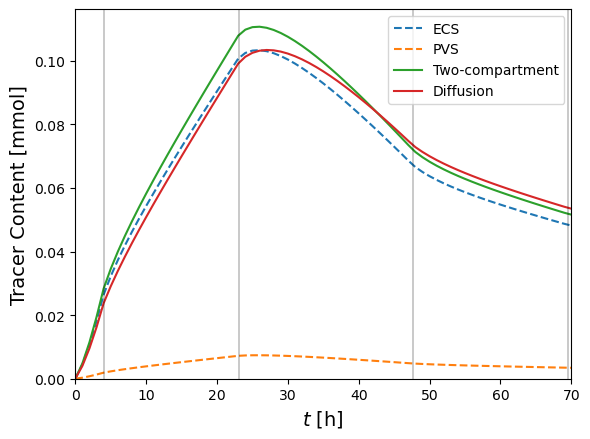

In [14]:
plt.figure()
plt.plot(t_sim, mass_ecs, '--', label="ECS")
plt.plot(t_sim, mass_pvs, '--', label="PVS")
plt.plot(t_sim, mass_total, label='Two-compartment')
plt.plot(t_sim, mass_diffusion, label="Diffusion")
# plt.plot(t_data, mass_data, "o-k", label="data")
plt.xticks(t_sim[::10], (t_sim[::10] / 3600).astype(int))
plt.xlabel(r"$t$ [h]", fontsize=14)
plt.ylabel(r"Tracer Content [mmol]", fontsize=14)
plt.ylim(0, None)
plt.xlim(t_sim[0], t_sim[-1])
for ti in t_data:
    plt.axvline(ti, color="k", ls="-", lw=0.3)
plt.legend()
plt.savefig("figures/concentration-curves.png", bbox_inches='tight')
plt.show()

###  MR-Image Comparison

Secondly, we want to compare the spatial variation of the simulation-results, by converting them from FEniCS-functions back to MRI-image format at the specific timepoints corresponding to the real measurement data. For this we use the script `fenics2mri.py`. However, since the two-compartment diffusion results are defined in terms of microscopic concentrations in a VectorElement-space, we first need to convert the data to the macroscopic concentrations. Note that this process takes quite a lot of time: Each conversion takes about 4-6 minutes each, and since we want to convert 5 timepoints * 2 functions = 10 conversions. 

In [9]:
from multidiffusion_model import (
    get_default_coefficients,
    print_progress
)

In [11]:
import subprocess

for sim_name in ["diffusion", "multidiffusion_total"]:
    subprocess.run(f"python fenics2mri.py --hdf5_name {sim_name}", shell=True)

INFO:root:Processing time 0 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [04:01<00:00, 10433.29it/s]
INFO:root:Processing time 4 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [04:03<00:00, 10355.69it/s]
INFO:root:Processing time 23 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [05:03<00:00, 8305.45it/s] 
INFO:root:Processing time 48 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [05:41<00:00, 7387.11it/s] 
INFO:root:Processing time 70 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [05:58<00:00, 7039.31it/s] 
INFO:root:Processing time 0 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [05:45<00:00, 7301.68it/s] 
INFO:root:Processing time 4 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [04:40<00:00, 9001.81it/s] 
INFO:root:Processing time 23 hours
  0%|          | 0/2524480 [00:00<?, ?it/s]

Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [04:11<00:00, 10035.31it/s]
INFO:root:Processing time 48 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [03:55<00:00, 10709.13it/s]
INFO:root:Processing time 70 hours


Computed mesh bounding box, evaluating 15% of all image voxels
There are 2524480 voxels in the bounding box


100%|██████████| 2524480/2524480 [03:55<00:00, 10711.15it/s]


Now that the images are converted to MR-format, we are able to plot them for a nicer spatial comparison between the two models.

In [22]:
def load_mri_data(fpath, slice_, mask=None):
    mri = nibabel.load(fpath)
    im = mri.get_fdata()[slice_]
    if mask is not None:
        im *= mask[slice_]
    return im 

In [31]:
slice_ = np.s_[:, 100, :]
im_ref = load_mri_data(datapath / "T1.mgz", slice_)

simpath = Path("figures")

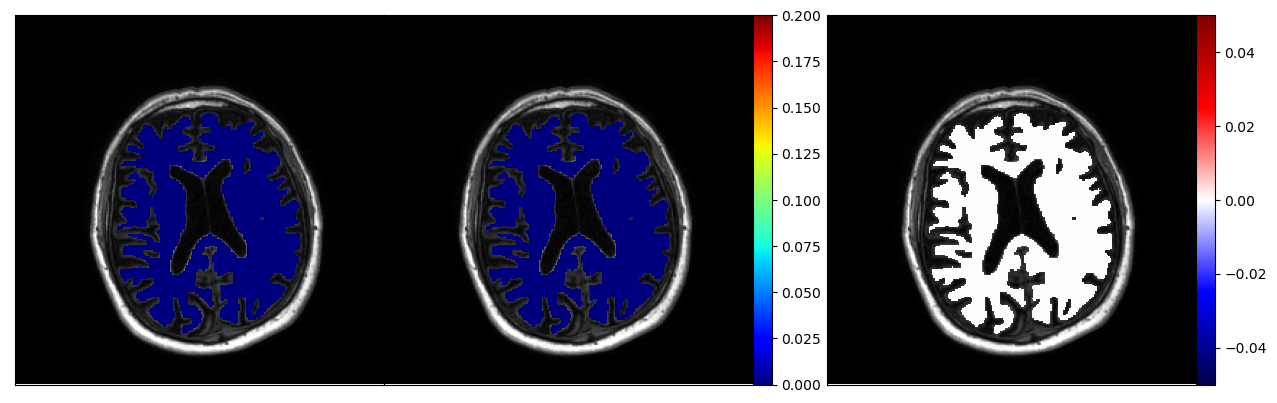

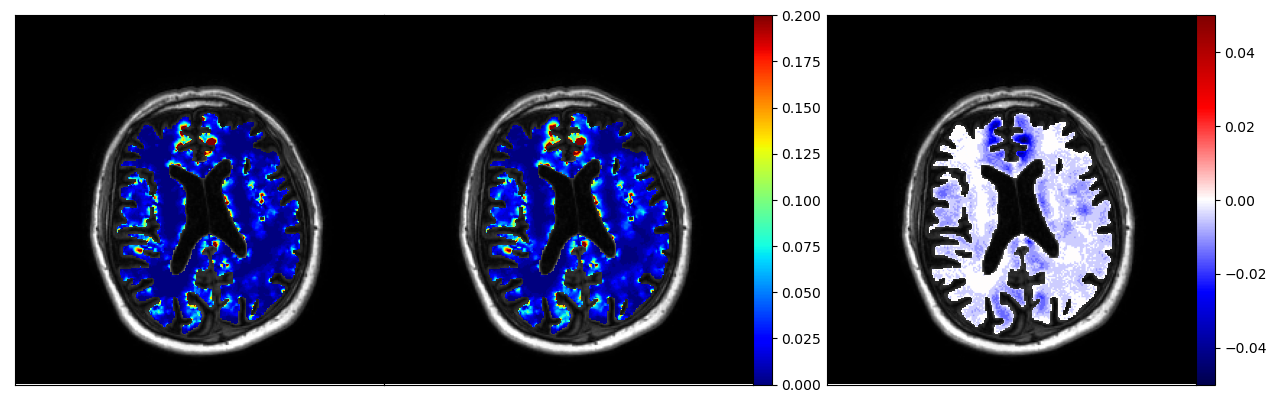

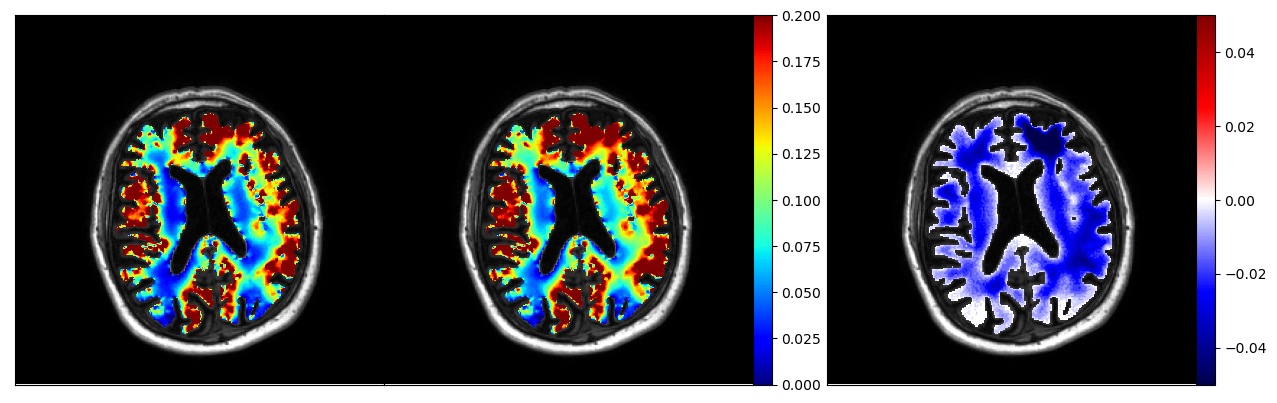

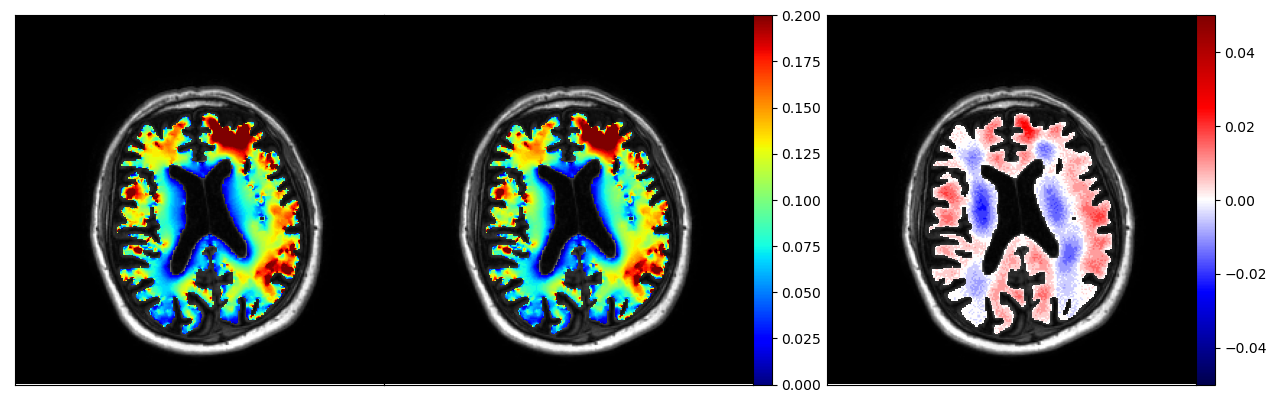

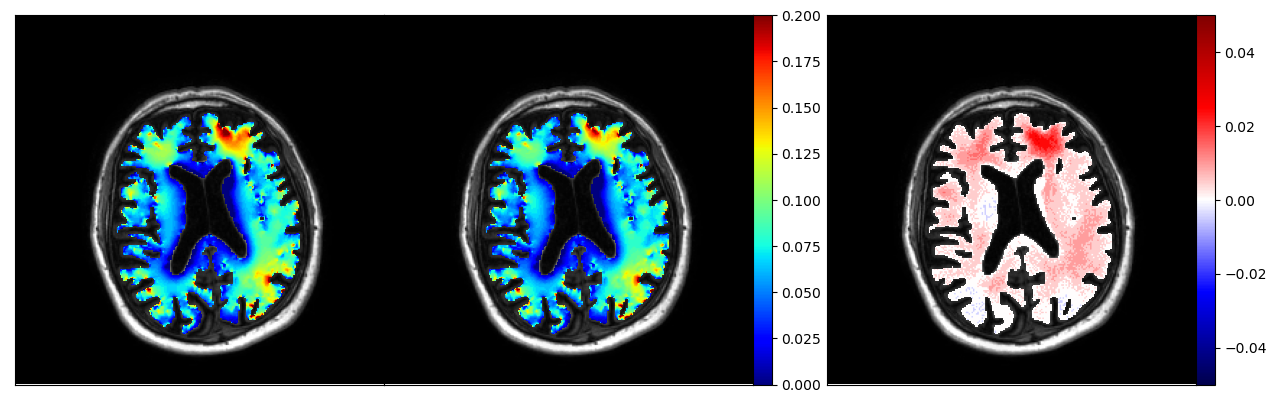

In [33]:
# Some setup for organizing subplots nicely.
W, H = im_ref.shape
d = 0.05 * W
gap = 0.15 * W
header = 0.1 * H
total_length = (3 * W + 2 * d + gap)
fig_width = 12
scale_factor = fig_width / total_length
fig_height = scale_factor * H
cbar_labelsize=10

def plot_comparison_row(
    im_ref,
    image1,
    image2,
    image3,
    diffmax,
    vrange,
    title=False
):
    vmin, vmax = vrange
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create axis for the diffusion-image 
    ax1 = fig.add_axes([0.0, 0.0, W / total_length, 1])
    ax1.imshow(im_ref.T, origin="lower", cmap="gray")
    c1 = ax1.imshow(image1.T, origin="lower", vmin=vmin, vmax=vmax, cmap="jet")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Create axis and plot the two-compartment diffusion image.
    ax2 = fig.add_axes([W / total_length, 0.0, W / total_length, 1])
    ax2.imshow(im_ref.T, origin="lower", cmap="gray")
    ax2.imshow(image2.T, origin="lower", vmin=vmin, vmax=vmax, cmap="jet")
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Create colorbar for the two first images.
    cax1 = fig.add_axes([2 * W / total_length, 0.0, d / total_length, 1])
    plt.colorbar(c1, cax=cax1)
    cax1.tick_params(labelsize=cbar_labelsize)

    # Plot the difference between the two images.
    ax3 = fig.add_axes([(2*W+gap+d)/ total_length, 0.0, W / total_length, 1])
    ax3.imshow(im_ref.T, origin="lower", cmap="gray")
    c2 = ax3.imshow(image3.T, cmap="seismic", vmin=-diffmax, vmax=diffmax, origin="lower")
    ax3.set_xticks([])
    ax3.set_yticks([])

    # Create colorbar for the last image.
    cax2 = fig.add_axes([(3*W+gap+d)/ total_length, 0.0, d / total_length, 1])
    plt.colorbar(c2, cax=cax2)
    cax2.tick_params(labelsize=cbar_labelsize)
    
    return fig

for idx, h in enumerate(hours):
    im_diffusion = load_mri_data(simpath / f"diffusion_{h:02d}.nii.gz", slice_, mask)
    im_multidiff = load_mri_data(simpath / f"multidiffusion_total_{h:02d}.nii.gz", slice_, mask)
    difference = im_diffusion - im_multidiff
    
    fig = plot_comparison_row(im_ref, im_diffusion, im_multidiff, difference, 0.05, (0, 0.2))#, title=(idx==0))
    plt.savefig(f"figures/model-comparison{h}.png", bbox_inches="tight")
    plt.show()